# Programmatically treatment


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer

from scipy import stats

import sys

sys.path.append("..")

from utils.visualization import model_test, model_pgrmlly_outlier_treatment
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import (
    balanced_accuracy_1interval_score,
    mean_absolute_1interval_error,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Inicialization


For the explanation of the method, which will be based on zscores, we will perform an example on position prediction in variable intervals.

Therefore, we will first initialize the data for this purpose.


In [2]:
df = pd.read_csv("../assets/data/processed/base_model.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

scorers = [
    make_scorer(balanced_accuracy_1interval_score),
    make_scorer(mean_absolute_1interval_error, greater_is_better=False),
]

X = pd.read_csv("../assets/data/processed/base_model_X.csv")
y = df["positionFinal"]

## Model test without treatment


Moreover, we will only test it on one model, knn, since it is only for method demonstration.

Therefore, let's see how well it works without applying the method and then apply it for comparison.


KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=100):
CV with make_scorer(balanced_accuracy_1interval_score): 0.3479507340302795
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.5176033175818326
              precision    recall  f1-score   support

           1       0.53      0.80      0.64       252
           2       0.52      0.81      0.63       252
           3       0.52      0.57      0.55       252
           4       0.44      0.47      0.45       252
           5       0.35      0.39      0.37       252
           6       0.34      0.46      0.39       252
           7       0.25      0.40      0.31       252
           8       0.36      0.31      0.33       252
           9       0.26      0.23      0.24       252
          10       0.28      0.24      0.26       252
          11       0.22      0.25      0.24       252
          12       0.26      0.37      0.30       252
          13       0.24      0.31      0.27       252
 

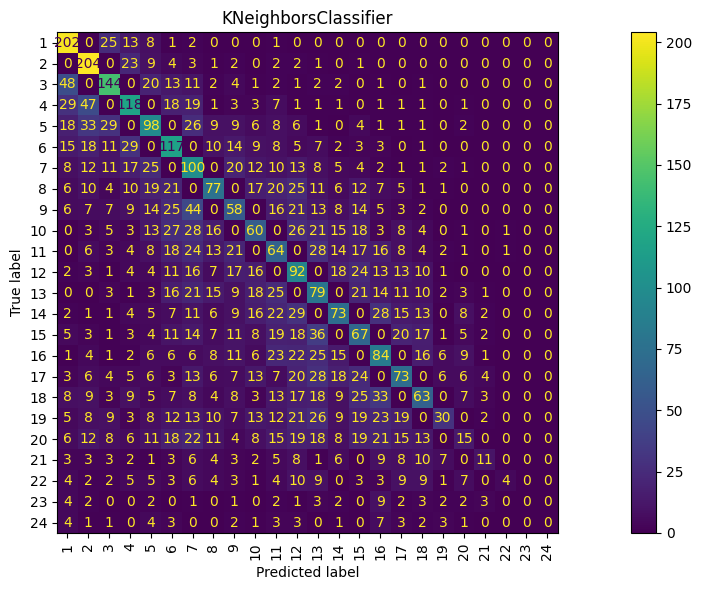

In [3]:
X_selected = X[
    [
        "positionGrid",
        "constructorRef",
        "driverWins",
    ]
]
knn = KNeighborsClassifier(
    n_neighbors=100, metric="manhattan", weights="uniform", n_jobs=-1
)
model_test((knn,), X_selected, y, tscv, scorers=scorers, interval=1)

## Treatment


Now we will check the dispersion of the data selected for training in order to see possible outliers.


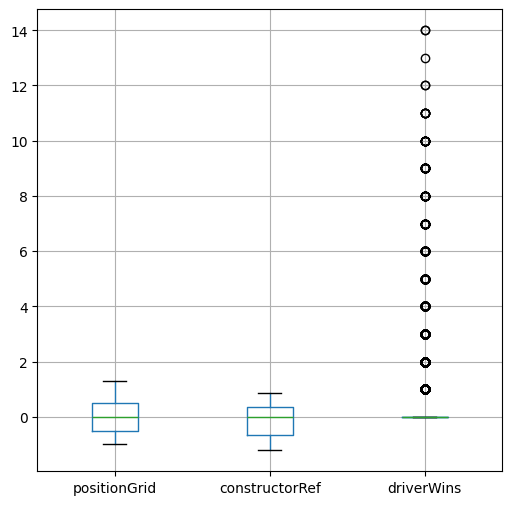

In [4]:
plt.rcParams["figure.figsize"] = (6, 6)
X_selected.boxplot()
plt.show()

We proceed to apply zscores, taking into account that we have a threshold that the higher the threshold the less instances will be eliminated and vice versa.


In [5]:
z_scores = np.abs(stats.zscore(X_selected))

threshold = 4

df_data_norm = df[(z_scores < threshold).all(axis=1)]
X_data_norm = X_selected[(z_scores < threshold).all(axis=1)]
y_data_norm = y[(z_scores < threshold).all(axis=1)]

print("Old shape:", X_selected.shape)
print("New shape:", X_data_norm.shape)
print("    * We have removed", X_selected.shape[0] - X_data_norm.shape[0], "instances")

Old shape: (7235, 3)
New shape: (7100, 3)
    * We have removed 135 instances


We see again the dispersion


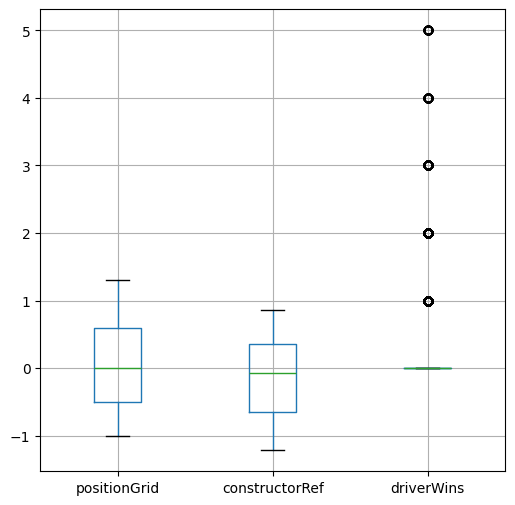

In [6]:
X_data_norm.boxplot()
plt.show()

## Model test with treatment


And we check the performance again, taking into account that when modifying the number of instances we have to recalculate the splits that will be computed


In [7]:
mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=100):


CV with make_scorer(balanced_accuracy_1interval_score): 0.34298846776119507
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.5727909278611056
              precision    recall  f1-score   support

           1       0.46      0.73      0.57       187
           2       0.49      0.79      0.60       229
           3       0.50      0.58      0.53       242
           4       0.44      0.46      0.45       248
           5       0.36      0.39      0.37       251
           6       0.33      0.47      0.39       251
           7       0.25      0.41      0.31       249
           8       0.39      0.31      0.34       252
           9       0.26      0.24      0.25       250
          10       0.29      0.23      0.26       252
          11       0.22      0.24      0.23       252
          12       0.24      0.35      0.29       252
          13       0.23      0.30      0.26       252
          14       0.32      0.29      0.30       252
          15    

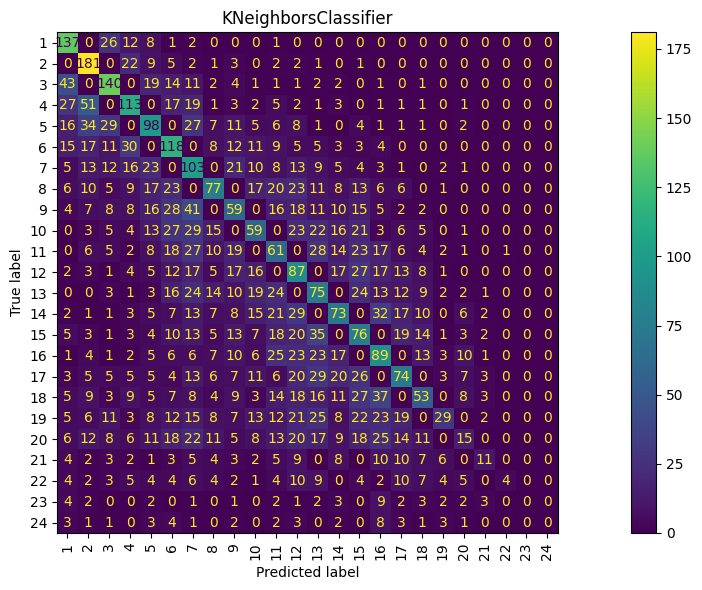

In [8]:
knn = KNeighborsClassifier(
    n_neighbors=100, metric="manhattan", weights="uniform", n_jobs=-1
)
model_test((knn,), X_data_norm, y_data_norm, tscv, scorers=scorers, interval=1)

As can be seen, it is worsening the result, specifically since it is taking the top positions as anomalies.

Note that this very detailed process will not be performed for all models, but a function has been defined that varies the thresholds and compares their behavior with the case in which the treatment would not have been performed.


Performance without treatment: 0.3479507340302795
Best performance with treatment:
     threshold = 8.000000000000004
     performance = 0.34845627016081565


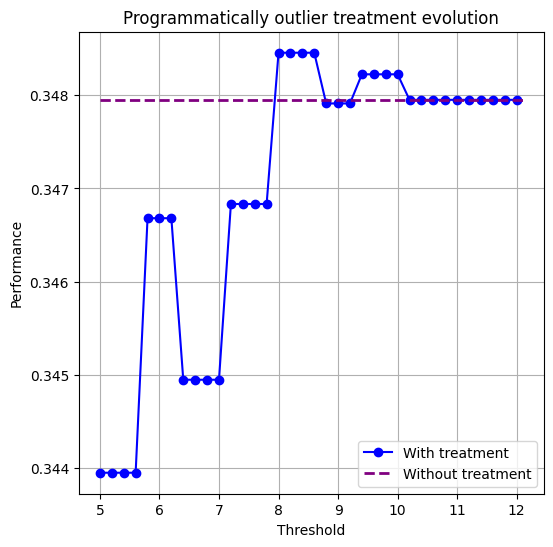

In [9]:
model_pgrmlly_outlier_treatment(
    KNeighborsClassifier(
        n_neighbors=100, metric="manhattan", weights="uniform", n_jobs=-1
    ),
    df,
    X_selected,
    y,
    scorers[0],
    (5, 12.1, 0.2),
)

In this case, for some thresholds, it has improved with respect to no treatment.
